In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vnstock import *
import sys                                                                              #hàm & biến để thao tác với môi trg runtime của python
np.random.seed(1)                                                                       #đảm bảo chuỗi ngẫu nhiên tạo ra cùng 1 kqua
import tensorflow as tf                                                                 #thư viện cho ML
tf.random.set_seed(2)
from tensorflow.keras.models import Sequential, load_model                              #tạo & tải mô hình ML
from tensorflow.keras.layers import Dense, LSTM                                         #lớp, xd lớp cho mô hình neural network
from tensorflow.keras import optimizers                                                 #tối ưu cho huấn luyện mô hình
from tensorflow.keras.callbacks import EarlyStopping                                    #ngừng huấn luyện mô hình khi không có cải thiện về độ lỗi trên tập kiểm tra                                                         #biểu đồ
from sklearn.preprocessing import MinMaxScaler                                          #chuẩn hóa dữ liệu về giữa [0,1]
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error  #chỉ số đánh giá hiệu suất mô hình
from math import sqrt
import datetime as dt
from datetime import date,datetime
import time
plt.style.use('ggplot')                                                                 #đặt phong cách biểu đồ

In [20]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

In [21]:
# Hàm lấy giá cổ phiếu
def get_stock_price(symbol):
    stock_hist = stock_historical_data(symbol, "2010-01-01",
        str(date.today()), "1D", "stock")
    stock_hist = stock_hist.rename(columns={'ticker': 'stock_name', 'time': 'date'})

    return stock_hist


In [22]:
data = get_stock_price('PLX')
data.drop(columns='stock_name',inplace=True)

data = data.set_index('date')
data

,open,high,low,close,volume
date,,,,,
2017-04-21,37670,37670,33450,35560,4820970
2017-04-24,35560,35990,34900,35200,1757390
2017-04-25,34980,35200,32759,32840,2533550
2017-04-26,31340,32360,31340,32070,1743790
2017-04-27,32070,33370,32070,33370,825430
...,...,...,...,...,...
2024-12-09,40450,40450,40000,40150,573300
2024-12-10,40150,40450,40100,40300,284700
2024-12-11,40200,40300,39850,39900,546600


In [23]:
ma_100_days = data.close.rolling(100).mean()
ma_100_days

date
2017-04-21        NaN
2017-04-24        NaN
2017-04-25        NaN
2017-04-26        NaN
2017-04-27        NaN
               ...   
2024-12-09    44126.0
2024-12-10    44060.0
2024-12-11    43995.5
2024-12-12    43934.5
2024-12-13    43856.5
Name: close, Length: 1915, dtype: float64

<Axes: xlabel='date'>

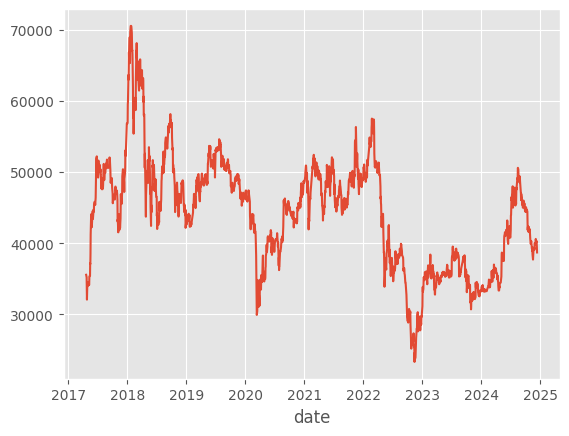

In [24]:
data = data.close
data.plot()


In [25]:
def fit_model(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data: vòng lặp cho dl train
    for i in range(timesteps, train.shape[0]):              #với i bắt đầu từ timesteps và train đầu tiên
        X_train.append(train[i-timesteps:i])                #chọn một phần của mảng train từ i-timesteps đến i -> thêm vào x_train => 1 ds các chuỗi, mỗi chuỗi có độ dài timesteps, sử dụng để huấn luyện
        Y_train.append(train[i])                            #lấy train thứ i -> thêm vào y_train -> 1 ds các gtrị muốn dự đoán (sẽ là gtri ngay cuối mỗi chuỗi của x_train)
    X_train, Y_train = np.array(X_train), np.array(Y_train) #lặp xong thì chuyển thành mảng numpy

    # Loop for val data: val dùng để kiểm tra hiệu suất model trong quá trình huấn luyện -> điều chỉnh
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model: thêm lớp vào mô hình
    model = Sequential()
    model.add(LSTM (1, input_shape=(X_train.shape[1] ,1), activation = 'relu', return_sequences = True))  #thêm 1 lớp vào model: số lg 1, shape đầu vào:(số bước tgian, số lg đặc trưng), trả về toàn bộ chuỗi đầu ra cho mỗi bước thời gian, kích hoạt relu -> có khả năng học phi tuyến tính
    for i in range(len(hl)-1):                                                                            #với i trong tập hl
        model.add(LSTM(hl[i], activation = 'relu', return_sequences = True))                              #thêm các lớp LSTM tiếp theo với số lượng đơn vị tương ứng trong hl[i]
    model.add(LSTM(hl[-1], activation = 'relu'))                                                          #Thêm lớp LSTM cuối cùng với số lượng đơn vị là phần tử cuối cùng trong hl
    model.add(Dense(1))                                                                                   #Thêm lớp Dense với 1 đơn vị đầu ra
    model.compile(optimizer = optimizers.Adam(learning_rate=lr), loss = 'mean_squared_error')                        #dùng Adam optimizer với tốc độ học lr, dùng mse để đánh giá
    print(model.summary())

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks = callbacks_list) #epoch: Số lượng lần lặp lại toàn bộ tập dữ liệu huấn luyện, 0 shuffle (trộn lại sau mỗi lần lặp)
    #model.reset_states() #đặt lại trạng thái của model
    return model, history.history['loss'], history.history['val_loss']                                    #trả về model đc huấn luyện, lịch sử mất mát trên tập train và val -> theo dõi hiệu suất model qua từng epoch

In [26]:
def evaluate_model(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

In [27]:
# Plotting the predictions: vẽ y_test và y_hat -> trực quan hoá kqua
def plot_data(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')                                 #test màu đỏ
    plt.plot(Y_hat, c = 'y')                                  #dự đoán màu vàng
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Univariate-LSTM")
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()  

In [28]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

(1915,)


<Axes: xlabel='date'>

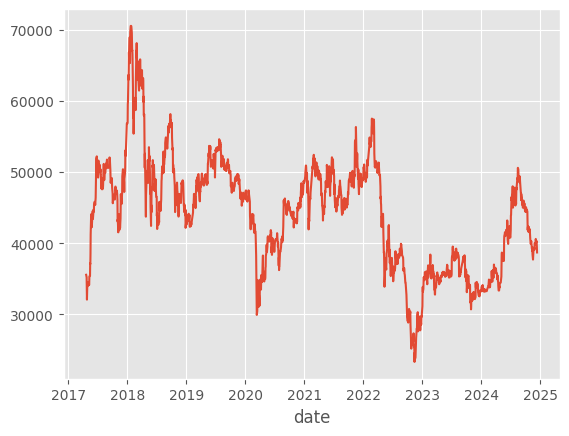

In [29]:
# Extracting the series
series = data
print(series.shape)
series.plot()

In [30]:
# Train Val Test Split
train_start = dt.date(2017, 4, 21)                                     #train để huấn luyện mô hình
train_end = dt.date(2022, 5, 16)
train_data = series.loc[train_start:train_end].values.reshape(-1, 1)

val_start = dt.date(2022, 5, 17)                                       #val để điều chỉnh siêu tham số và tránh overfitting
val_end = dt.date(2023, 8, 14)
val_data = series.loc[val_start:val_end].values.reshape(-1, 1)

test_start = dt.date(2023, 9, 15)                                      #test để đánh giá hiệu suất
test_end = dt.date(2024, 12, 13)
test_data = series.loc[test_start:test_end].values.reshape(-1, 1)

print(train_data.shape, val_data.shape, test_data.shape)    

(1265, 1) (315, 1) (314, 1)


In [31]:
# Normalisation: chuẩn hoá -> model hiệu quả hơn
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler() #thu nhỏ về khoảng [0,1]
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape, val.shape, test.shape)

(1265, 1) (315, 1) (314, 1)


In [32]:
#siêu tham số
timesteps = 30    #sử dụng 40 gtri trước để dự đoán gtri tiếp theo
hl = [40,35]      #hidden layers: cấu trúc lớp ẩn
lr = 1e-3      #learning rate: tốc  độ học
batch_size = 64   #số lg mẫu đc sử dụng trong mỗi lần cập nhật trọng số
num_epochs = 50  #số lần mà toàn bộ dl đc đưa qua model

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 1)          │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 40)         │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 35)             │        10,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,408 (68.00 KB)

 Trainable params: 17,408 (68.00 KB)

 Non-trainable params: 0 (0.00 B)

None


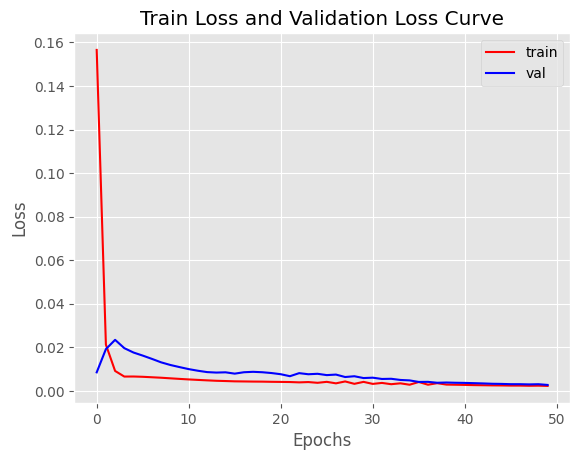

In [33]:
model, train_error, val_error = fit_model(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
MSE = 0.0010886357685373138
RMSE = 0.032994480879948905
MAPE = 0.20209666775100393
R-Squared Score = 0.9371651362473535


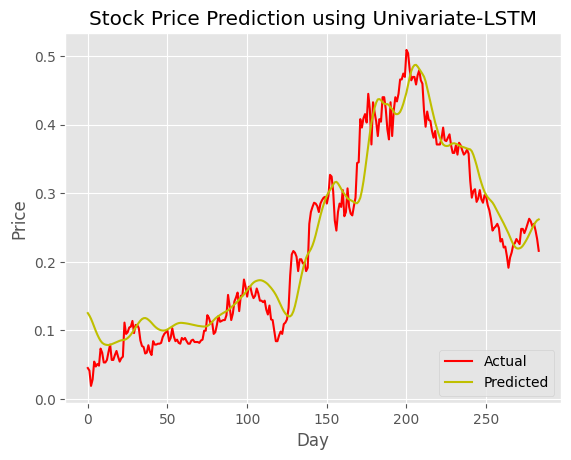

<Figure size 640x480 with 0 Axes>

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data(true, predicted)


In [35]:
model.save('stock_prediction.h5')